In [46]:
import pandas as pd
import networkx as nx
from pathlib import Path

# Local paths (no URL)
nodes_path = Path("graph_nodes.csv") if Path("graph_nodes.csv").exists() else Path("data/graph_nodes.csv")
edges_path = Path("graph_edges.csv") if Path("graph_edges.csv").exists() else Path("data/graph_edges.csv")

# Read CSVs
nodes = pd.read_csv(nodes_path)
edges = pd.read_csv(edges_path)

# Build undirected graph from edge list (columns: ID1, ID2)
G = nx.from_pandas_edgelist(edges, source="ID1", target="ID2", create_using=nx.Graph())

# Attach node attributes: all columns except 'ID'
attr = nodes.set_index("ID").to_dict("index")
G.add_nodes_from(attr.keys())
nx.set_node_attributes(G, attr)

print(G)

# Print the first 5 nodes with attributes
for i, (node, data) in enumerate(G.nodes(data=True)):
    if i >= 5:
        break
    print(f"Node {node}: {data}")

# Graph with 130 nodes and 806 edges
# Node 0: {'Age': 20, 'Gender': 'female', 'Hobbies': 'hiking,gaming'}
# Node 1: {'Age': 68, 'Gender': 'male', 'Hobbies': 'art,hiking,reading,travel'}
# Node 3: {'Age': 27, 'Gender': 'male', 'Hobbies': 'dancing,hiking'}
# Node 16: {'Age': 54, 'Gender': 'female', 'Hobbies': 'art,cooking,gaming'}
# Node 20: {'Age': 24, 'Gender': 'male', 'Hobbies': 'dancing'}


Graph with 130 nodes and 806 edges
Node 0: {'Age': 20, 'Gender': 'female', 'Hobbies': 'hiking,gaming'}
Node 1: {'Age': 68, 'Gender': 'male', 'Hobbies': 'art,hiking,reading,travel'}
Node 3: {'Age': 27, 'Gender': 'male', 'Hobbies': 'dancing,hiking'}
Node 16: {'Age': 54, 'Gender': 'female', 'Hobbies': 'art,cooking,gaming'}
Node 20: {'Age': 24, 'Gender': 'male', 'Hobbies': 'dancing'}


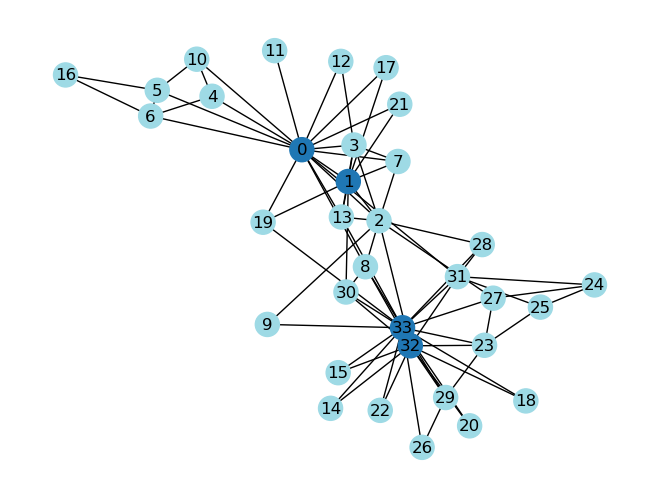

In [86]:
def fit_dcsbm(G, q=None, deg_corr=True):
    import graph_tool.all as gt
    from graph_tool.inference import minimize_blockmodel_dl, BlockState
    # convert networkx -> graph-tool preserving node order
    nodes = list(G.nodes())
    g = gt.Graph(directed=False)
    g.add_vertex(len(nodes))
    idx = {n: i for i, n in enumerate(nodes)}
    for u, v in G.edges():
        g.add_edge(g.vertex(idx[u]), g.vertex(idx[v]))
    # fit model (q fixes number of blocks when provided)
    state_args = dict(deg_corr=deg_corr)
    if q is None:
        state = minimize_blockmodel_dl(g, state=BlockState, state_args=state_args)
    else:
        state = minimize_blockmodel_dl(g, state=BlockState, state_args=state_args, multilevel_mcmc_args=dict(B_min=q, B_max=q))
    labels = list(state.get_blocks())
    # re-label blocks to 0,...,q-1
    unique_labels = sorted(set(labels))
    label_map = {old: new for new, old in enumerate(unique_labels)}
    labels = [label_map[l] for l in labels]
    # map labels back to original networkx node order
    return [labels[idx[n]] for n in nodes]

# Import the Karate Club graph
karate = nx.karate_club_graph()

# Fit a DCSBM to the graph
labels = fit_dcsbm(karate, q=2, deg_corr=True)

pos = nx.spring_layout(karate, seed=43)
nx.draw(karate, pos, node_color=labels, cmap='tab20', with_labels=True)

In [87]:
# Title: Louvain 1. Run the Louvain community detection algorithm on G for 100 times using louvain_communities from networkx.algorithms.community. Which of
# the following statement is/are true?
# a. The average number of communities found across all runs is strictly between 4.5 and 5.5.
# b. The average modularity score across all the runs is greater than 0.25.
# c. The node with the largest degree is found in the community with the largest average degree in more than 30% of all the runs.
# d. The most frequently observed number of communities across all the runs is 5 or 6.

from collections import Counter
from networkx.algorithms.community import louvain_communities, modularity

runs = 100
# Pre-compute degrees and the node with largest degree
deg = dict(G.degree())
max_deg_node = max(deg, key=deg.get)

num_comms = []
mods = []
hits_c = 0  # count of runs where statement (c) holds

for i in range(runs):
    comms = louvain_communities(G)
    num_comms.append(len(comms))
    mods.append(modularity(G, comms))

    # Average degree per community
    avg_deg_per_comm = [sum(deg[n] for n in c) / len(c) for c in comms]

    # Index of the community containing the max-degree node
    idx_node_comm = next(j for j, c in enumerate(comms) if max_deg_node in c)
    # Index of the community with the largest average degree
    idx_max_avg_comm = max(range(len(avg_deg_per_comm)), key=lambda j: avg_deg_per_comm[j])

    if idx_node_comm == idx_max_avg_comm:
        hits_c += 1

avg_num_comms = sum(num_comms) / runs
avg_modularity = sum(mods) / runs
pct_c = hits_c / runs

# Mode (most frequently observed) number of communities
mode_num_comms = Counter(num_comms).most_common(1)[0][0]

# Evaluate statements
A = 4.5 < avg_num_comms < 5.5
B = avg_modularity > 0.25
C = pct_c > 0.30
D = mode_num_comms in (5, 6)

print(f"Runs: {runs}")
print(f"Average number of communities: {avg_num_comms:.3f}")
print(f"Average modularity: {avg_modularity:.3f}")
print(f"Fraction (c) satisfied: {pct_c:.3f}")
print(f"Most frequent number of communities: {mode_num_comms}")
print("Statements true:")
print("a.", A)
print("b.", B)
print("c.", C)
print("d.", D)

Runs: 100
Average number of communities: 5.830
Average modularity: 0.261
Fraction (c) satisfied: 0.050
Most frequent number of communities: 6
Statements true:
a. False
b. True
c. False
d. True


In [135]:
# Title: SBM Fitting 2. Fit a standard Stochastic Block Model (SBM) with Bernoulli edge distribution to G with q=3 for 100 runs using fit_dcsbm (with 
# deg_corr=False). Which of the following statement is/are true?
# a. The average size of the largest community is strictly between 90 and 100.
# b. The average size of the smallest community is strictly above 20.
# c. The node with the largest degree is found in the community with the largest average degree in more than 30% of all the runs.
# d. The average within-block edge density exceeds the average between-block edge density.

# SBM (deg_corr=False) with q=3 for 100 runs; evaluate (a)–(d)
from collections import defaultdict

runs = 100
nodes_list = list(G.nodes())
deg = dict(G.degree())
max_deg_node = max(deg, key=deg.get)

largest_sizes = []
smallest_sizes = []
within_densities = []
between_densities = []
hits_c = 0

for i in range(runs):
    labels = fit_dcsbm(G, q=3, deg_corr=False)

    # Map node -> block label
    label_of = {nodes_list[k]: labels[k] for k in range(len(nodes_list))}

    # Build communities
    comms_dict = defaultdict(list)
    for n, b in label_of.items():
        comms_dict[b].append(n)
    comms = list(comms_dict.values())

    # Sizes
    sizes = [len(c) for c in comms]
    largest_sizes.append(max(sizes))
    smallest_sizes.append(min(sizes))

    # Statement (c): compare community of max-degree node vs community with largest avg degree
    avg_deg_per_comm = [sum(deg[n] for n in c) / len(c) for c in comms]
    idx_node_comm = next(j for j, c in enumerate(comms) if max_deg_node in c)
    idx_max_avg_comm = max(range(len(avg_deg_per_comm)), key=lambda j: avg_deg_per_comm[j])
    if idx_node_comm == idx_max_avg_comm:
        hits_c += 1

    # Densities: within and between
    block_sizes = {b: len(c) for b, c in comms_dict.items()}
    within_counts = {b: 0 for b in comms_dict.keys()}
    between_counts = defaultdict(int)

    for u, v in G.edges():
        bu, bv = label_of[u], label_of[v]
        if bu == bv:
            within_counts[bu] += 1
        else:
            key = (bu, bv) if bu < bv else (bv, bu)
            between_counts[key] += 1

    # Average within-block edge density across blocks with at least 2 nodes
    within_vals = []
    for b, n_b in block_sizes.items():
        if n_b > 1:
            possible = n_b * (n_b - 1) / 2
            within_vals.append(within_counts[b] / possible)
    within_d = sum(within_vals) / len(within_vals) if within_vals else 0.0
    within_densities.append(within_d)

    # Average between-block edge density across all block pairs
    labels_sorted = sorted(block_sizes.keys())
    between_vals = []
    for i1 in range(len(labels_sorted)):
        for i2 in range(i1 + 1, len(labels_sorted)):
            b1, b2 = labels_sorted[i1], labels_sorted[i2]
            e = between_counts[(b1, b2)]
            possible = block_sizes[b1] * block_sizes[b2]
            between_vals.append(e / possible)
    between_d = sum(between_vals) / len(between_vals) if between_vals else 0.0
    between_densities.append(between_d)

# Aggregate results across runs
avg_largest = sum(largest_sizes) / runs
avg_smallest = sum(smallest_sizes) / runs
pct_c = hits_c / runs
avg_within = sum(within_densities) / runs
avg_between = sum(between_densities) / runs

# Evaluate statements
A = 90 < avg_largest < 100
B = avg_smallest > 20
C = pct_c > 0.30
D = avg_within > avg_between

print(f"Runs: {runs}")
print(f"Average largest community size: {avg_largest:.3f}")
print(f"Average smallest community size: {avg_smallest:.3f}")
print(f"Fraction (c) satisfied: {pct_c:.3f}")
print(f"Average within-block density: {avg_within:.4f}")
print(f"Average between-block density: {avg_between:.4f}")
print("Statements true:")
print("a.", A)
print("b.", B)
print("c.", C)
print("d.", D)

Runs: 100
Average largest community size: 83.010
Average smallest community size: 15.400
Fraction (c) satisfied: 0.480
Average within-block density: 0.1494
Average between-block density: 0.1023
Statements true:
a. False
b. False
c. True
d. True


In [ ]:
# Title: DCSBM Fitting 3. Fit a Degree-Corrected Stochastic Block Model (DCSBM) with Poisson edge distribution to G with q=3 for 100 runs using fit_dcsbm.
# Which of the following statement is/are true?
# a. The average size of the largest community is strictly between 80 and 100.
# b. The average size of the smallest community is strictly above 20.
# c. The node with the largest degree is found in the community with the largest average degree in more than 40% of all the runs.
# d. The average within-block edge density exceeds the average between-block edge density.

# DCSBM (deg_corr=True) with q=3 for 100 runs; evaluate (a)–(d)
from collections import defaultdict

runs = 100
nodes_list = list(G.nodes())
deg = dict(G.degree())
max_deg_node = max(deg, key=deg.get)

largest_sizes = []
smallest_sizes = []
within_densities = []
between_densities = []
hits_c = 0

for i in range(runs):
    labels = fit_dcsbm(G, q=3, deg_corr=True)

    # Map node -> block label
    label_of = {nodes_list[k]: labels[k] for k in range(len(nodes_list))}

    # Build communities
    comms_dict = defaultdict(list)
    for n, b in label_of.items():
        comms_dict[b].append(n)
    comms = list(comms_dict.values())

    # Sizes
    sizes = [len(c) for c in comms]
    largest_sizes.append(max(sizes))
    smallest_sizes.append(min(sizes))

    # Statement (c): compare community of max-degree node vs community with largest avg degree
    avg_deg_per_comm = [sum(deg[n] for n in c) / len(c) for c in comms]
    idx_node_comm = next(j for j, c in enumerate(comms) if max_deg_node in c)
    idx_max_avg_comm = max(range(len(avg_deg_per_comm)), key=lambda j: avg_deg_per_comm[j])
    if idx_node_comm == idx_max_avg_comm:
        hits_c += 1

    # Densities: within and between
    block_sizes = {b: len(c) for b, c in comms_dict.items()}
    within_counts = {b: 0 for b in comms_dict.keys()}
    between_counts = defaultdict(int)

    for u, v in G.edges():
        bu, bv = label_of[u], label_of[v]
        if bu == bv:
            within_counts[bu] += 1
        else:
            key = (bu, bv) if bu < bv else (bv, bu)
            between_counts[key] += 1

    # Average within-block edge density across blocks with at least 2 nodes
    within_vals = []
    for b, n_b in block_sizes.items():
        if n_b > 1:
            possible = n_b * (n_b - 1) / 2
            within_vals.append(within_counts[b] / possible)
    within_d = sum(within_vals) / len(within_vals) if within_vals else 0.0
    within_densities.append(within_d)

    # Average between-block edge density across all block pairs
    labels_sorted = sorted(block_sizes.keys())
    between_vals = []
    for i1 in range(len(labels_sorted)):
        for i2 in range(i1 + 1, len(labels_sorted)):
            b1, b2 = labels_sorted[i1], labels_sorted[i2]
            e = between_counts[(b1, b2)]
            possible = block_sizes[b1] * block_sizes[b2]
            between_vals.append(e / possible)
    between_d = sum(between_vals) / len(between_vals) if between_vals else 0.0
    between_densities.append(between_d)

# Aggregate results across runs
avg_largest = sum(largest_sizes) / runs
avg_smallest = sum(smallest_sizes) / runs
pct_c = hits_c / runs
avg_within = sum(within_densities) / runs
avg_between = sum(between_densities) / runs

# Evaluate statements
A = 80 < avg_largest < 100
B = avg_smallest > 20
C = pct_c > 0.40
D = avg_within > avg_between

print(f"Runs: {runs}")
print(f"Average largest community size: {avg_largest:.3f}")
print(f"Average smallest community size: {avg_smallest:.3f}")
print(f"Fraction (c) satisfied: {pct_c:.3f}")
print(f"Average within-block density: {avg_within:.4f}")
print(f"Average between-block density: {avg_between:.4f}")
print("Statements true:")
print("a.", A)
print("b.", B)
print("c.", C)
print("d.", D)

Runs: 100
Average largest community size: 93.960
Average smallest community size: 11.050
Fraction (c) satisfied: 0.170
Average within-block density: 0.1597
Average between-block density: 0.1423
Statements true:
a. True
b. False
c. False
d. True


n=130, E=806, m=6, runs=100
G: transitivity=0.1128, ASPL(LCC)=2.2016, k_max=22
BA avg: transitivity=0.1686, ASPL(LCC)=2.1916, k_max=48.81
Statements true:
a. True
b. False
c. True
d. (visual)


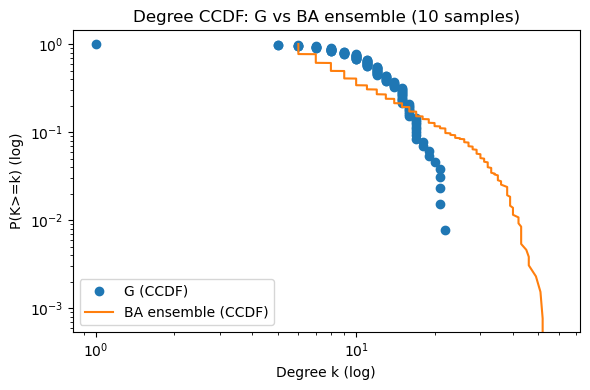

In [ ]:
# Title: Preferential Attachment Comparison 4. Simulate 100 realisations of the Barabási-Albert (BA) graph, each generated so that the final number of
# vertices matches that of G and m chosen to give a similar number of edges as G. 
# Use a complete graph on m+1 vertices as the initial graph. Which of the following statements is/are true?
# a. The global clustering coefficient (transitivity) of G is smaller than the average transitivity of the BA graphs.
# b. The maximum degree of G is larger than the average maximum degree across the BA ensemble.
# c. The average shortest path length of G and the BA ensemble mean are within 5% of each other.
# d. The degree distribution of G is closer to a power law than those of the BA graphs (visualise the CCDF of the degree distribution of G on a log-log plot and compare against the CCDFs of the BA graphs).

import math
import random
import numpy as np
import matplotlib.pyplot as plt

# Helper: BA with custom initial complete graph K_{m+1}
def barabasi_albert_with_complete_seed(n, m, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    # Start from K_{m+1}
    G0 = nx.complete_graph(m + 1)
    # If n <= m+1, just return the subgraph
    if n <= m + 1:
        return G0.subgraph(range(n)).copy()
    # Use standard BA growth from this seed graph
    return nx.barabasi_albert_graph(n=n, m=m, seed=seed, initial_graph=G0)

# Match node/edge counts
n = G.number_of_nodes()
E = G.number_of_edges()
# Choose m so that expected edges ~ E; BA has ~ m*(n-1) edges
m = max(1, round(E / max(1, (n - 1))))

runs = 100
ba_trans = []
ba_aspl = []  # average shortest path length of LCC
ba_kmax = []

# Metrics for original G
G_trans = nx.transitivity(G)
# Work on largest connected component for ASPL to avoid infinity
G_lcc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(G_lcc_nodes)
G_aspl = nx.average_shortest_path_length(G_lcc)
G_kmax = max(dict(G.degree()).values())

for r in range(runs):
    H = barabasi_albert_with_complete_seed(n, m )
    ba_trans.append(nx.transitivity(H))
    H_lcc_nodes = max(nx.connected_components(H), key=len)
    H_lcc = H.subgraph(H_lcc_nodes)
    ba_aspl.append(nx.average_shortest_path_length(H_lcc))
    ba_kmax.append(max(dict(H.degree()).values()))

avg_ba_trans = float(np.mean(ba_trans))
avg_ba_aspl = float(np.mean(ba_aspl))
avg_ba_kmax = float(np.mean(ba_kmax))

# Evaluate statements
A = G_trans < avg_ba_trans
B = G_kmax > avg_ba_kmax
C = abs(G_aspl - avg_ba_aspl) / avg_ba_aspl <= 0.05

print(f"n={n}, E={E}, m={m}, runs={runs}")
print(f"G: transitivity={G_trans:.4f}, ASPL(LCC)={G_aspl:.4f}, k_max={G_kmax}")
print(f"BA avg: transitivity={avg_ba_trans:.4f}, ASPL(LCC)={avg_ba_aspl:.4f}, k_max={avg_ba_kmax:.2f}")
print("Statements true:")
print("a.", A)
print("b.", B)
print("c.", C)
print("d. (visual)")

# (d) CCDF on log-log: compare degree distributions
G_deg = np.array([d for _, d in G.degree()])
H_deg_all = np.concatenate([np.array([d for _, d in barabasi_albert_with_complete_seed(n, m, seed=1000 + i).degree()]) for i in range(10)])

# CCDF helper
def ccdf(x):
    x_sorted = np.sort(x)
    y = 1.0 - np.arange(1, len(x_sorted) + 1) / len(x_sorted)
    return x_sorted, y

xG, yG = ccdf(G_deg)
xH, yH = ccdf(H_deg_all)

plt.figure(figsize=(6, 4))
plt.loglog(xG[xG>0], yG[xG>0], 'o', label='G (CCDF)')
plt.loglog(xH[xH>0], yH[xH>0], '-', label='BA ensemble (CCDF)')
plt.xlabel('Degree k (log)')
plt.ylabel('P(K>=k) (log)')
plt.title('Degree CCDF: G vs BA ensemble (10 samples)')
plt.legend()
plt.tight_layout()
plt.show()

In [172]:
# Title: Random Geometric Graph Comparison 5. Simulate 100 Random Geometric Graphs on the unit square, each with the same number of nodes as G and with
# radius r chosen to give a similar number of edges as G (adjust for boundary effects). Which of the following statements is/are true? 
# a. The average clustering coefficient of G is lower than the average clustering coefficient of the RGG ensemble.
# b. The average shortest path length of the largest connected component of G is within 5% of the average of the same metric across the RGG ensemble.
# c. More than 90% of the RGGs are fully connected.
# d. The maximum degree observed in G is within 5% of the average maximum degree across the RGG ensemble.

import math
import numpy as np

# Choose radius r to roughly match G's edge density in unit square: p ~ pi r^2
n = G.number_of_nodes()
E = G.number_of_edges()
p = (2 * E) / (n * (n - 1))  # edge probability equivalent for simple graphs
r = max(1e-6, math.sqrt(max(0.0, p) / math.pi))

# adjust for boundary effects in unit square
r *= 1.1

runs = 100
rgg_clustering = []
rgg_aspl = []
rgg_kmax = []
connected_count = 0

# Metrics for G
G_clust = nx.average_clustering(G)
G_lcc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(G_lcc_nodes)
G_aspl = nx.average_shortest_path_length(G_lcc)
G_kmax = max(dict(G.degree()).values())

for i in range(runs):
    H = nx.random_geometric_graph(n, r, pos=None)
    # connectivity
    is_conn = nx.is_connected(H)
    connected_count += int(is_conn)

    # clustering (use whole graph)
    rgg_clustering.append(nx.average_clustering(H))

    # average shortest path length on LCC
    H_lcc_nodes = max(nx.connected_components(H), key=len)
    H_lcc = H.subgraph(H_lcc_nodes)
    rgg_aspl.append(nx.average_shortest_path_length(H_lcc))

    # max degree
    rgg_kmax.append(max(dict(H.degree()).values()))

avg_rgg_clust = float(np.mean(rgg_clustering))
avg_rgg_aspl = float(np.mean(rgg_aspl))
avg_rgg_kmax = float(np.mean(rgg_kmax))
frac_connected = connected_count / runs

# Evaluate statements
A = G_clust < avg_rgg_clust
B = abs(G_aspl - avg_rgg_aspl) / avg_rgg_aspl <= 0.05
C = frac_connected > 0.90
D = abs(G_kmax - avg_rgg_kmax) / avg_rgg_kmax <= 0.05

print(f"n={n}, E={E}, r~{r:.4f}, runs={runs}")
print(f"G: avg_clustering={G_clust:.4f}, ASPL(LCC)={G_aspl:.4f}, k_max={G_kmax}")
print(f"RGG avg: avg_clustering={avg_rgg_clust:.4f}, ASPL(LCC)={avg_rgg_aspl:.4f}, k_max={avg_rgg_kmax:.2f}")
print(f"RGG fraction connected: {frac_connected:.3f}")
print("Statements true:")
print("a.", A)
print("b.", B)
print("c.", C)
print("d.", D)

n=130, E=806, r~0.1924, runs=100
G: avg_clustering=0.1136, ASPL(LCC)=2.2016, k_max=22
RGG avg: avg_clustering=0.6500, ASPL(LCC)=3.7626, k_max=22.46
RGG fraction connected: 0.970
Statements true:
a. True
b. False
c. True
d. True


In [ ]:
# Title: SBM and Node Attributes 6. Fit a standard Stochastic Block Model (SBM) with Bernoulli edge distribution to G with q=3 for 100 runs using
# fit_dcsbm (deg_corr=False). Which of the following statements is/are true?
# a. The average age is significantly different across the three communities (check whether in more than 10 out of the 100 runs the lowest average age 
# among the three communities is 10% less than that of the highest average age among the three communities).
# b. The distribution of the gender attribute is significantly different across the three communities (do a chi-squared test for independence based on a 
# contingency table using the pandas crosstab function and check whether more than 10 out of the 100 simulations are significant).
# c. In over 90% of the runs, one community is composed of more than 60% 'male' nodes.
# d. G shows age correlation among connections (correlation coefficient larger than 0.1).

import numpy as np
from collections import defaultdict
from scipy.stats import chi2_contingency

runs = 100
nodes_list = list(G.nodes())
ages = nx.get_node_attributes(G, 'Age')
genders = nx.get_node_attributes(G, 'Gender')

# (d) Age correlation among connections: compute Pearson correlation of endpoint ages over edges
age_pairs = [(ages[u], ages[v]) for u, v in G.edges() if u in ages and v in ages]
if age_pairs:
    a_u, a_v = zip(*age_pairs)
    a_u = np.asarray(a_u, dtype=float)
    a_v = np.asarray(a_v, dtype=float)
    # correlation of (a_u, a_v)
    corr_d = float(np.corrcoef(a_u, a_v)[0, 1])
else:
    corr_d = 0.0

age_spread_signif = 0
chi2_signif = 0
male60_runs = 0

for i in range(runs):
    labels = fit_dcsbm(G, q=3, deg_corr=False)

    # Map node -> block
    label_of = {nodes_list[k]: labels[k] for k in range(len(nodes_list))}

    # Build communities
    comms_dict = defaultdict(list)
    for n, b in label_of.items():
        comms_dict[b].append(n)
    comms = list(comms_dict.values())

    # (a) Average ages per community
    avg_ages = []
    for c in comms:
        a = [ages[n] for n in c if n in ages]
        if len(a) > 0:
            avg_ages.append(sum(a) / len(a))
    if len(avg_ages) >= 2:
        if min(avg_ages) <= 0.9 * max(avg_ages):
            age_spread_signif += 1

    # (b) Chi-squared test for gender distribution across communities
    # Build contingency table rows=communities, cols=genders (male/female/others if present)
    gender_vals = sorted(set(g for g in genders.values()))
    if len(gender_vals) > 1:
        table = []
        for c in comms:
            counts = {g: 0 for g in gender_vals}
            for n in c:
                g = genders.get(n, None)
                if g in counts:
                    counts[g] += 1
            table.append([counts[g] for g in gender_vals])
        chi2, p, dof, exp = chi2_contingency(table)
        if p < 0.05:
            chi2_signif += 1

    # (c) >60% male in at least one community
    has_male60 = False
    for c in comms:
        if len(c) == 0:
            continue
        males = sum(1 for n in c if genders.get(n) == 'male')
        if males / len(c) > 0.60:
            has_male60 = True
            break
    if has_male60:
        male60_runs += 1

# Aggregate
A = age_spread_signif > 10
B = chi2_signif > 10
C = male60_runs / runs > 0.90
D = corr_d > 0.10

print(f"Runs={runs}")
print(f"(a) runs with >=10% age spread: {age_spread_signif}")
print(f"(b) runs with chi-square p<0.05: {chi2_signif}")
print(f"(c) fraction runs with a community >60% male: {male60_runs / runs:.3f}")
print(f"(d) age correlation across edges: r={corr_d:.3f}")
print("Statements true:")
print("a.", A)
print("b.", B)
print("c.", C)
print("d.", D)